In [37]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(11) # It's my lucky number
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools


In [38]:
import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import backend as K


In [39]:
folder_benign_train = 'C:/Users/Zak/Desktop/Major Project/medical_analysis_machine_learning-master/Skin_Cancer_detection/data/train/benign'

folder_malignant_train = 'C:/Users/Zak/Desktop/Major Project/medical_analysis_machine_learning-master/Skin_Cancer_detection/data/train/malignant'

folder_benign_test = 'C:/Users/Zak/Desktop/Major Project/medical_analysis_machine_learning-master/Skin_Cancer_detection/data/test/benign'
folder_malignant_test = 'C:/Users/Zak/Desktop/Major Project/medical_analysis_machine_learning-master/Skin_Cancer_detection/data/test/malignant'

read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

In [40]:
# Load in training pictures
ims_benign = [read(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array(ims_malignant, dtype='uint8')


In [41]:
# Load in testing pictures
ims_benign = [read(os.path.join(folder_benign_test, filename)) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array(ims_malignant, dtype='uint8')

In [42]:
# Create labels
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])

In [43]:
# Merge data
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)


In [44]:
# Shuffle data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]


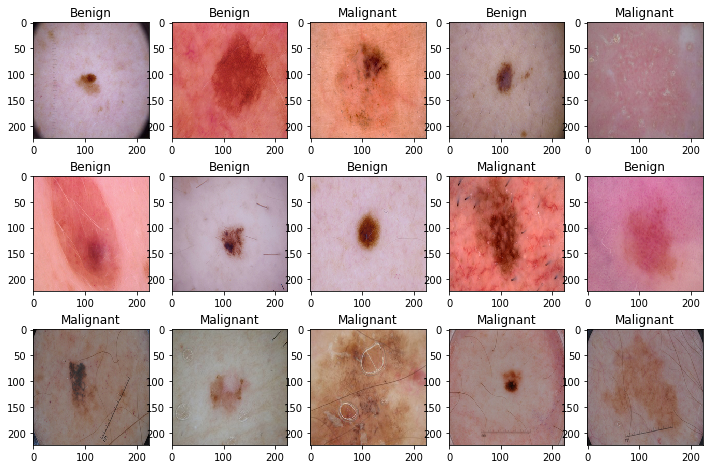

In [45]:
# Display first 15 images of moles, and how they are classified
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()


In [11]:
# ---------- Step 3: Categorical Labels --------------

# Turn labels into one hot encoding

y_train = to_categorical(y_train, num_classes= 2)
y_test = to_categorical(y_test, num_classes= 2)


In [12]:

# --------------- Step 4 : Normalization

# Normalize all Values of the pictures by dividing all the RGB values by 255

# With data augmentation to prevent overfitting
X_train = X_train/255.
X_test = X_test/255.

Train on 2109 samples, validate on 528 samples
Epoch 1/5
2109/2109 - 2855s - loss: 0.6788 - acc: 0.7368 - val_loss: 8.2430 - val_acc: 0.4640
Epoch 2/5
2109/2109 - 3182s - loss: 0.4601 - acc: 0.7933 - val_loss: 7.1361 - val_acc: 0.5360
Epoch 3/5
2109/2109 - 5685s - loss: 0.5617 - acc: 0.8103 - val_loss: 8.2430 - val_acc: 0.4640
Epoch 4/5
2109/2109 - 2830s - loss: 0.4348 - acc: 0.7904 - val_loss: 6.6089 - val_acc: 0.4848
Epoch 5/5
2109/2109 - 2766s - loss: 0.4543 - acc: 0.8075 - val_loss: 6.2368 - val_acc: 0.4716
dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])


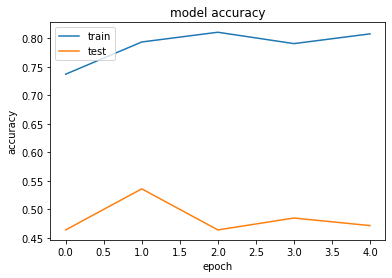

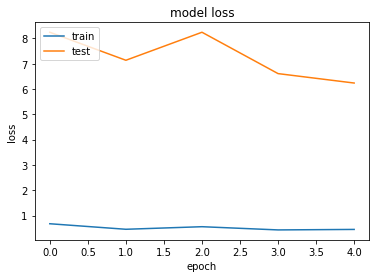

0.6515151515151515
Saved model to disk


In [15]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='acc',
                                            patience=5,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=1e-6)


input_shape = (224,224,3)
lr = 1e-5
epochs = 5
batch_size = 64

model = ResNet50(include_top=True,
                 weights= None,
                 input_tensor=None,
                 input_shape=input_shape,
                 pooling='avg',
                 classes=2)

model.compile(optimizer= 'adam' ,
              loss= keras.losses.binary_crossentropy, metrics=['acc'])


history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, verbose=2,
                    callbacks=[learning_rate_reduction]
                   )

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Train ResNet50 on all the data
model.fit(X_train, y_train,
          epochs=epochs, batch_size= epochs, verbose=0,
          callbacks=[learning_rate_reduction]
         )

# Testing model on test data to evaluate
y_pred = model.predict(X_test)
print(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

# save model
# serialize model to JSON
resnet50_json = model.to_json()

with open("resnet50.json", "w") as json_file:
    json_file.write(resnet50_json)

# serialize weights to HDF5
model.save_weights("resnet50.h5")
print("Saved model to disk")

In [48]:
print(y_pred)

[[0.3887496  0.6112504 ]
 [0.6157665  0.38423344]
 [0.7148763  0.2851237 ]
 ...
 [0.3323813  0.66761875]
 [0.36944887 0.6305511 ]
 [0.4322351  0.56776494]]


In [69]:
t = y_pred
pred = t[:,1]
for i in range(0,pred.shape[0]-1): 
    if pred[i]>=0.5:
        pred[i]=1
    else:
        pred[i]=0


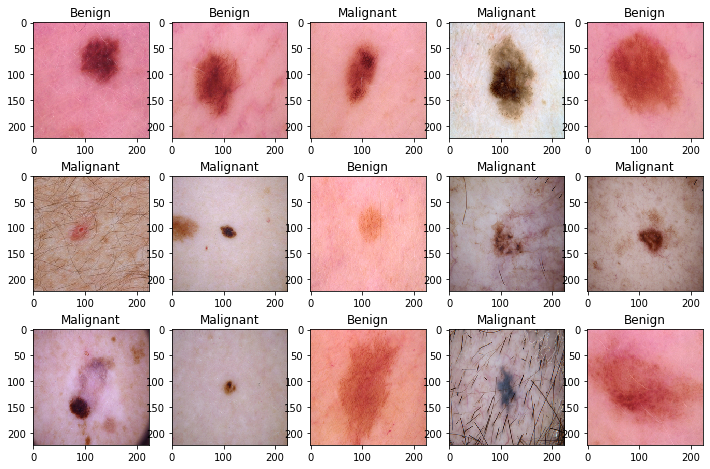

In [66]:
# Display first 15 images of moles, and how they are predicted
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if pred[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_test[i], interpolation='nearest')
plt.show()

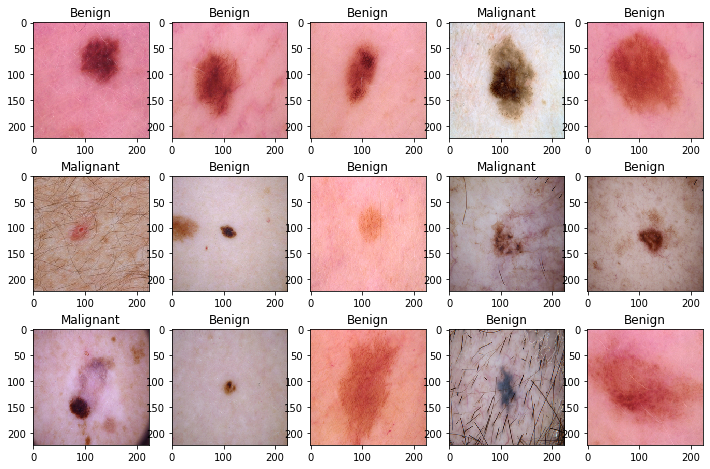

In [68]:
# Display actual 15 images of moles, and how they are classified
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_test[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_test[i], interpolation='nearest')
plt.show()